In [1]:
from scipy.sparse.linalg import splu, factorized
from scipy.linalg import lu_factor, lu_solve
import numpy as np
np.set_printoptions(precision=4) # Print few decimal places
np.set_printoptions(suppress=True) # Suppress scientific notation
import cvxpy as cp
import pandas as pd
from numpy.linalg import cholesky as llt
import matplotlib.pyplot as plt
import scipy.stats as stats
import time
import pulp
import gurobipy as gp
import scipy.io
from scipy.sparse import csc_matrix
np.set_printoptions(threshold=np.inf, linewidth=200)
import gurobipy as grb

Problem is
$$\text{min } \frac{1}{2} x^TQx+p^Tx$$

$$\text{s.t. } Ax+s=b$$

$$s \in C$$

where $C = \{0\}^{eq} \text{ x } R_+^{ineq}$

ADMM:
$$x^{k+1} = argmin_x \{\frac{1}{2}x^TQx + p^Tx + (\rho / 2)||Ax+s^k-b - (1/\rho)y^k||_2^2 \}$$

$$s^{k+1} = argmin_{\{s\in C\}} \{(\rho/2)||Ax^{k+1} + s - b - (1/\rho)y^k||_2^2\}$$

$$y^{k+1} = y^k - \rho (Ax^{k+1} + s^{k+1} -b)$$

$$\hat{y}^{k+1} = y^k - \rho (Ax^{k+1} + s^{k} -b)$$

Closed form (if $Q + \rho  A^T A$ is full column rank):

$$x^{k+1} = (Q + \rho A^T A)^{-1} (-p + \rho A^T (s^k - b - (1/\rho)y^k))$$

$$s^{k+1} = proj_{\bold(C)} (-(Ax^{k+1} -b - (1/\rho)y^k ) )$$

P.S. $Q + \rho  A^T A$ is invertible for all of the tested problems

In [2]:
linear = ['PRIMAL1', 'PRIMAL2', 'PRIMAL3', 'PRIMAL4', 'DUAL3',]

prob = ['QBANDM', 'QBEACONF', 'QBORE3D', 'QBRANDY', 'QCAPRI', 'QE226', 'QFORPLAN', 'QGROW7',
        'QISRAEL', 'QPCBLEND', 'QPCBOEI1', 'QPCBOEI2', 'QPCSTAIR', 'GOULDQP2', 'EXDATA', 
        'LASER', 'MOSARQP1', 'MOSARQP2', 'PRIMAL1', 'PRIMAL2', 'PRIMAL3', 'PRIMAL4', 'Q25FV47',
        'GOULDQP2' ,'GOULDQP3', 'DUAL3', 'CVXQP1_M', 'AUG3D', 'AUG2D']
not_tested = ['EXDATA', 'LASER', 'MOSARQP1', 'MOSARQP2', 'QBORE3D', 'QCAPRI', 'QE226', 'QFORPLAN',
              'QGROW7', 'QPCBLEND']
weird = ['QBEACONF', 'QBRANDY', 'QISRAEL']

k = 0

mat_data = scipy.io.loadmat(f"C:/Users/baice/Desktop/Junior Year 2nd Sem/ORF 498/QP Problems/{prob[k]}.mat")

print("Problem =", prob[k])

Q_mat = mat_data['Q'].toarray()
A_mat = mat_data['A'].toarray()
c_mat = mat_data['c'].flatten()
rl_mat = mat_data['rl'].flatten()
ru_mat = mat_data['ru'].flatten()
lb_mat = mat_data['lb'].flatten()
ub_mat = mat_data['ub'].flatten()

Problem = QBANDM


Getting Objective value with different formulations

In [3]:
x = cp.Variable(Q_mat.shape[1])
objective = cp.Minimize(0.5 * cp.quad_form(x, Q_mat) + c_mat.T @ x)
constraints = [A_mat @ x <= ru_mat, rl_mat <= A_mat @ x, x <= ub_mat, lb_mat <= x]
problem = cp.Problem(objective, constraints)

# The solvers often fail so we try multiple
lp_solvers = ['CLARABEL', 'GUROBI', 'OSQP', 'SCIPY', 'GLPK', 'GLPK_MI', 'SCS']
for solver in lp_solvers:
    try:
        if solver == 'CLARABEL':
            problem.solve(solver=solver, tol_gap_abs=1e-10, tol_gap_rel=1e-10,tol_feas=1e-10, tol_ktratio=1e-10)
        elif solver == 'GUROBI':
            problem.solve(solver=solver, FeasibilityTol=1e-9, OptimalityTol=1e-9)
        elif solver =='OSQP':
            problem.solve(solver=solver, eps_abs=1e-10, eps_rel=1e-7, eps_prim_inf=1e-10, eps_dual_inf=1e-7)
        elif solver == 'SCIPY':
            problem.solve(solver=solver, scipy_options={"gtol":1e-10, "xtol":1e-10})
        elif solver == 'SCS':
            problem.solve(solver=solver, eps_abs=1e-10, eps_rel=1e-7)
        else:
            problem.solve(solver=solver, tol_gap_abs=1e-10, tol_gap_rel=1e-10, tol_feas=1e-10, tol_ktratio=1e-10)
        if problem.status in ['optimal', 'infeasible','unbounded']:
            break
    except Exception as e:
        print(f"Solver {solver} failed. ErrorL {e}")

print("OBJ 1 =", objective.value)



x = cp.Variable(Q_mat.shape[1])
objective = cp.Minimize(0.5 * cp.quad_form(x, Q_mat) + c_mat.T @ x)
constraints = [A_mat @ x <= ru_mat, rl_mat <= A_mat @ x, x <= ub_mat, lb_mat <= x]
problem = cp.Problem(objective, constraints)

lp_solvers = ['CLARABEL', 'GUROBI', 'OSQP', 'SCIPY', 'GLPK', 'GLPK_MI', 'SCS']
for solver in lp_solvers:
    try:
        if solver == 'CLARABEL':
            problem.solve(solver=solver, tol_gap_abs=1e-10, tol_gap_rel=1e-10,tol_feas=1e-10, tol_ktratio=1e-10)
        elif solver == 'GUROBI':
            problem.solve(solver=solver, FeasibilityTol=1e-9, OptimalityTol=1e-9)
        elif solver =='OSQP':
            problem.solve(solver=solver, eps_abs=1e-10, eps_rel=1e-7, eps_prim_inf=1e-10, eps_dual_inf=1e-7)
        elif solver == 'SCIPY':
            problem.solve(solver=solver, scipy_options={"gtol":1e-10, "xtol":1e-10})
        elif solver == 'SCS':
            problem.solve(solver=solver, eps_abs=1e-10, eps_rel=1e-7)
        else:
            problem.solve(solver=solver, tol_gap_abs=1e-10, tol_gap_rel=1e-10, tol_feas=1e-10, tol_ktratio=1e-10)
        if problem.status in ['optimal', 'infeasible','unbounded']:
            break
    except Exception as e:
        print(f"Solver {solver} failed. ErrorL {e}")
        
print("OBJ 2 =", objective.value)




x = cp.Variable(Q_mat.shape[1])
objective = cp.Minimize(0.5 * cp.quad_form(x, Q_mat) + c_mat.T @ x)
constraints = [A_mat @ x <= ru_mat, -A_mat @ x <= -rl_mat, x <= ub_mat, -x <= -lb_mat]
problem = cp.Problem(objective, constraints)

lp_solvers = ['CLARABEL', 'GUROBI', 'OSQP', 'SCIPY', 'GLPK', 'GLPK_MI', 'SCS']
for solver in lp_solvers:
    try:
        if solver == 'CLARABEL':
            problem.solve(solver=solver, tol_gap_abs=1e-10, tol_gap_rel=1e-10,tol_feas=1e-10, tol_ktratio=1e-10)
        elif solver == 'GUROBI':
            problem.solve(solver=solver, FeasibilityTol=1e-9, OptimalityTol=1e-9)
        elif solver =='OSQP':
            problem.solve(solver=solver, eps_abs=1e-10, eps_rel=1e-7, eps_prim_inf=1e-10, eps_dual_inf=1e-7)
        elif solver == 'SCIPY':
            problem.solve(solver=solver, scipy_options={"gtol":1e-10, "xtol":1e-10})
        elif solver == 'SCS':
            problem.solve(solver=solver, eps_abs=1e-10, eps_rel=1e-7)
        else:
            problem.solve(solver=solver, tol_gap_abs=1e-10, tol_gap_rel=1e-10, tol_feas=1e-10, tol_ktratio=1e-10)
        if problem.status in ['optimal', 'infeasible','unbounded']:
            break
    except Exception as e:
        print(f"Solver {solver} failed. ErrorL {e}")

print("OBJ 3 =",objective.value)



n = A_mat.shape[1]
m = A_mat.shape[0]

A = np.copy(A_mat)
ul = np.copy(ru_mat)
rl = np.copy(rl_mat)

A = np.array(np.zeros(n))
b = np.array([0])

# This cleanign is done as it will be used later for ADMM as having "inf" as a value will cause issues
#       Wierdly enough this always produces an answer that is slightly different from the other formulations
for i in range(m):
    if ru_mat[i] != np.inf:
        A = np.vstack([A, A_mat[i,:]])
        b = np.hstack([b, ru_mat[i]])
    if rl_mat[i] != -np.inf:
        A = np.vstack([A, -A_mat[i,:]])
        b = np.hstack([b, -rl_mat[i]])

for i in range(n):
    if ub_mat[i] != np.inf:
        new_row = np.zeros(n)
        new_row[i] = 1
        A = np.vstack([A, new_row])
        b = np.hstack([b, ub_mat[i]])
    if lb_mat[i] != -np.inf:
        new_row = np.zeros(n)
        new_row[i] = -1
        A = np.vstack([A, new_row])
        b = np.hstack([b, -lb_mat[i]])

# This isn't used do to issues with some values being "inf"
# A = np.vstack([A, -A, -np.eye(n)])
# b = np.hstack([ul, -rl, -lb_mat])

x_cvxpy = cp.Variable(A.shape[1])
s_cvxpy = cp.Variable(b.shape[0])
objective = cp.Minimize(0.5*cp.quad_form(x_cvxpy, Q_mat) + c_mat.T @ x_cvxpy)
# Without slack variables (compact version of actual formulation)
constraints = [A @ x_cvxpy <= b]

problem = cp.Problem(objective, constraints)

lp_solvers = ['CLARABEL', 'GUROBI', 'OSQP', 'SCIPY', 'GLPK', 'GLPK_MI', 'SCS']
for solver in lp_solvers:
    try:
        if solver == 'CLARABEL':
            problem.solve(solver=solver, tol_gap_abs=1e-10, tol_gap_rel=1e-10,tol_feas=1e-10, tol_ktratio=1e-10)
        elif solver == 'GUROBI':
            problem.solve(solver=solver, FeasibilityTol=1e-9, OptimalityTol=1e-9)
        elif solver =='OSQP':
            problem.solve(solver=solver, eps_abs=1e-10, eps_rel=1e-7, eps_prim_inf=1e-10, eps_dual_inf=1e-7)
        elif solver == 'SCIPY':
            problem.solve(solver=solver, scipy_options={"gtol":1e-10, "xtol":1e-10})
        elif solver == 'SCS':
            problem.solve(solver=solver, eps_abs=1e-10, eps_rel=1e-7)
        else:
            problem.solve(solver=solver, tol_gap_abs=1e-10, tol_gap_rel=1e-10, tol_feas=1e-10, tol_ktratio=1e-10)
        if problem.status in ['optimal', 'infeasible','unbounded']:
            break
    except Exception as e:
        print(f"Solver {solver} failed. ErrorL {e}")


print("OBJ 4 =",problem.value)




x_cvxpy = cp.Variable(A.shape[1])
s_cvxpy = cp.Variable(b.shape[0])
objective = cp.Minimize(0.5*cp.quad_form(x_cvxpy, Q_mat) + c_mat.T @ x_cvxpy)
# With slack variables
#       The first type is if instead of having "<=" & ">=" for the constraint matrix we have all "="
#       The second is if we have "<=" & ">=" (also ok if "=")
# constraints = [A @ x_cvxpy + s_cvxpy == b, s_cvxpy[m:] >= 0, s_cvxpy[:m] == 0]
constraints = [A @ x_cvxpy + s_cvxpy == b, s_cvxpy >= 0]
problem = cp.Problem(objective, constraints)

lp_solvers = ['CLARABEL', 'GUROBI', 'OSQP', 'SCIPY', 'GLPK', 'GLPK_MI', 'SCS']
for solver in lp_solvers:
    try:
        if solver == 'CLARABEL':
            problem.solve(solver=solver, tol_gap_abs=1e-10, tol_gap_rel=1e-10,tol_feas=1e-10, tol_ktratio=1e-10)
        elif solver == 'GUROBI':
            problem.solve(solver=solver, FeasibilityTol=1e-9, OptimalityTol=1e-9)
        elif solver =='OSQP':
            problem.solve(solver=solver, eps_abs=1e-10, eps_rel=1e-7, eps_prim_inf=1e-10, eps_dual_inf=1e-7)
        elif solver == 'SCIPY':
            problem.solve(solver=solver, scipy_options={"gtol":1e-10, "xtol":1e-10})
        elif solver == 'SCS':
            problem.solve(solver=solver, eps_abs=1e-10, eps_rel=1e-7)
        else:
            problem.solve(solver=solver, tol_gap_abs=1e-10, tol_gap_rel=1e-10, tol_feas=1e-10, tol_ktratio=1e-10)
        if problem.status in ['optimal', 'infeasible','unbounded']:
            break
    except Exception as e:
        print(f"Solver {solver} failed. ErrorL {e}")

print("OBJ 5 =",problem.value)

print("\nNote that the objective values are slightly different. Not sure if this is a precision thing or what, as the formulations should all be equivalent.\n")

# 1707904.150247648

OBJ 1 = 16352.342037402675
OBJ 2 = 16352.342037402675
OBJ 3 = 16352.342037402675
OBJ 4 = 16352.3420375675
OBJ 5 = 16352.342044821213

Note that the objective values are slightly different. Not sure if this is a precision thing or what, as the formulations should all be equivalent.



In [4]:
def plot_results(ADMM, ADMM_custom, label_custom):
    fig, ax = plt.subplots(1, 5, figsize=(20,5), constrained_layout=True)
    
    ax[0].plot(ADMM[0], label='ADMM')
    ax[0].set_yscale('log')
    ax[0].set_ylabel('Dual Residual')
    ax[0].set_xlabel('Iteration')

    ax[1].plot(ADMM[1], label='ADMM')
    ax[1].set_yscale('log')
    ax[1].set_ylabel('Primal Residual')
    ax[1].set_xlabel('Iteration')

    ax[2].plot(ADMM[2], label='ADMM')
    ax[2].set_yscale('log')
    ax[2].set_ylabel('Duality Gap')
    ax[2].set_xlabel('Iteration')

    ax[3].plot(ADMM[3], label='ADMM')
    ax[3].set_yscale('log')
    ax[3].set_ylabel('KKT Value')
    ax[3].set_xlabel('Iteration')

    ax[4].plot(ADMM[4], label='ADMM')
    ax[4].set_yscale('log')
    ax[4].set_ylabel('ADMM value - optimal')
    ax[4].set_xlabel('Iteration')
    
    
    
    ax[0].plot(ADMM_custom[0], label=label_custom)

    ax[1].plot(ADMM_custom[1], label=label_custom)

    ax[2].plot(ADMM_custom[2], label=label_custom)

    ax[3].plot(ADMM_custom[3], label=label_custom)

    ax[4].plot(ADMM_custom[4], label=label_custom)
    
    
    
    # Plot against a linear convergence
    k_value = np.arange(0, len(ADMM[0]), 1)
    y_value = (0.997) ** k_value
    ax[0].plot(y_value, label=r"$y=0.997^k$", linewidth=2.5)

    y_value = (0.995) ** k_value
    ax[1].plot(y_value, label=r"$y=0.995^k$", linewidth=2.5)

    y_value = (0.997) ** k_value
    ax[2].plot(y_value, label=r"$y=0.997^k$", linewidth=2.5)
    ax[3].plot(y_value, label=r"$y=0.995^k$", linewidth=2.5)
    ax[4].plot(y_value, label=r"$y=0.997^k$", linewidth=2.5)
    
    
    # Plot against a sublinear convergence
    k_value = np.arange(0, len(ADMM[0]), 1)
    y_value = 1 / k_value

    ax[0].plot(y_value, label=r"$y=1/k$", linewidth=2.5)
    ax[0].legend()

    ax[1].plot(y_value, label=r"$y=1/k$", linewidth=2.5)
    ax[1].legend()

    ax[2].plot(y_value, label=r"$y=1/k$", linewidth=2.5)
    ax[2].legend()

    ax[3].plot(y_value, label=r"$y=1/k$", linewidth=2.5)
    ax[3].legend()

    ax[4].plot(y_value, label=r"$y=1/k$", linewidth=2.5)
    ax[4].legend()
    
    return

In [5]:
def ADMM_imported_mat(Q, p, A, b, x, s, y, rho, n, m, lu):
    # # CVXPY
    # var1 = cp.Variable(x.shape[0])
    # constraint1 = []
    # objective = cp.Minimize(0.5*cp.quad_form(var1, Q) + p.T @ var1 + (rho/2)*cp.sum_squares(A@var1+s-b-(1/rho)*y))
    # prob1 = cp.Problem(objective, constraint1)
    # prob1.solve()
    # x_next = var1.value
    
    # var2 = cp.Variable(s.shape[0])
    # constraint2 = [var2[:m] == 0, var2[m:] >= 0]
    # objective = cp.Minimize((rho/2)*cp.sum_squares(A@x_next+var2-b-(1/rho)*y))
    # prob2 = cp.Problem(objective, constraint2)
    # prob2.solve()
    # s_next = var2.value
    
    
    # Closed form solution
    d = -p - rho * A.T @ s + rho * A.T @ b + A.T @ y
    x_next = lu.solve(d)
    
    
    # C = Q + rho * A.T @ A
    # d = -p - rho * A.T @ s + rho * A.T @ b + A.T @ y
    # x_next = np.linalg.solve(C, d)
    
    
    term = -(A @ x_next - b - (1/rho) * y)
    
    s_next = np.zeros(s.shape[0])
    # for i in range(len(s_next)):
    #     s_next[i] = max(0, term[i])
    s_next[m:] = np.clip(term[m:], 0, None)
        
    
    y_next = y - rho*(A@x_next + s_next - b)
    y_hat_next = y - rho*(A@x_next + s - b)
    
    z_hat_next = [x_next, s_next, y_hat_next]
    z_next = [x_next, s_next, y_next]
    
    
    return z_hat_next, z_next

In [6]:

def KKT_error_imported_mat(w, Q, p, A, b, x, s, y, m, n, ub_indx, lb_indx, matrix_constraint, Q_inv, val):
    norm1 = np.linalg.norm(A@x + s - b, 2) ** 2
    
    ub_matrix = []
    for i in ub_indx:
        new_row = np.zeros(n)
        new_row[i] = 1
        ub_matrix.append(new_row)
    
    ub_matrix = np.array(ub_matrix)
        
    # lb_matrix = []
    # for i in lb_indx:
    #     new_row = np.zeros(n)
    #     new_row[i] = 1
    #     lb_matrix.append(new_row)
        
    # lb_matrix = np.array(lb_matrix)

    # if ub_matrix.shape[0] > 0 and lb_matrix.shape[0] > 0:
    #     b_matrix = np.vstack([np.zeros((m,n)), ub_matrix, lb_matrix])
    # elif lb_matrix.shape[0] > 0:
    #     b_matrix = np.vstack([np.zeros((m,n)), lb_matrix])
    # elif ub_matrix.shape[0] > 0:
    #     b_matrix = np.vstack([np.zeros((m,n)), ub_matrix])
    # else:
    #     print("ERROR")

    
    # norm2 = np.linalg.norm(np.minimum(Q@x + p - (A.T+b_matrix.T) @ y,0), 2) ** 2
    norm2 = np.linalg.norm(np.minimum(Q@x + p - matrix_constraint @ y,0), 2) ** 2
    
    # The last term should be adjusted to be one of the proposed duality gap metrics
    # KKT = np.sqrt(w**2 * norm1 + (1/(w**2)) * norm2 + (b.T@y - 0.5*x.T@Q@x - p.T@x) ** 2)
    
    # Uses the QP Duality gap
    KKT = np.sqrt(w**2 * norm1 + (1/(w**2)) * norm2 + (x.T @ Q @ x + p.T @ x - b.T @ y) ** 2)
    # KKT = np.sqrt(w**2 * norm1 + (1/(w**2)) * norm2 + (0.5*(p + matrix_constraint @ y).T @ Q_inv @ (p + matrix_constraint @ y) - y.T @ b + val) ** 2)
    
    return KKT

Pure ADMM

The duality gap of $f(x) - g(y)$ is:
$$[(1/2) x^T Q x + p^T x ] - [-(1/2) (p - (A^T + B^T) y)^T Q^{\dagger} (p - (A^T + B^T) y) - y^T b]$$

At optimality, aka when the duality gap is 0, the duality gap is:
$$x^T Q x + p^T x + b^T y = 0$$

Where $Q^\dagger$ is the pseudo inverse of Q





NOTE: I am not sure which one should be used for testing purposes or which to implement in the KKT Restarts. I am leanning more towards the second version of the duality gap as that, I think, would be the one in the spirit of the KKT conditions we learned in class

Did cvxpy converge = optimal
cvxpy value = 16352.342044821135

Q + rho * A.T @ A is invertible => True 



C:\Users\baice\AppData\Local\Temp\ipykernel_4076\360511430.py:78: SparseEfficiencyWarning: splu converted its input to CSC format
  lu = splu(matrix_x)


ADMM value = 16352.429138287747


C:\Users\baice\AppData\Local\Temp\ipykernel_4076\600647710.py:59: RuntimeWarning: divide by zero encountered in divide
  y_value = 1 / k_value


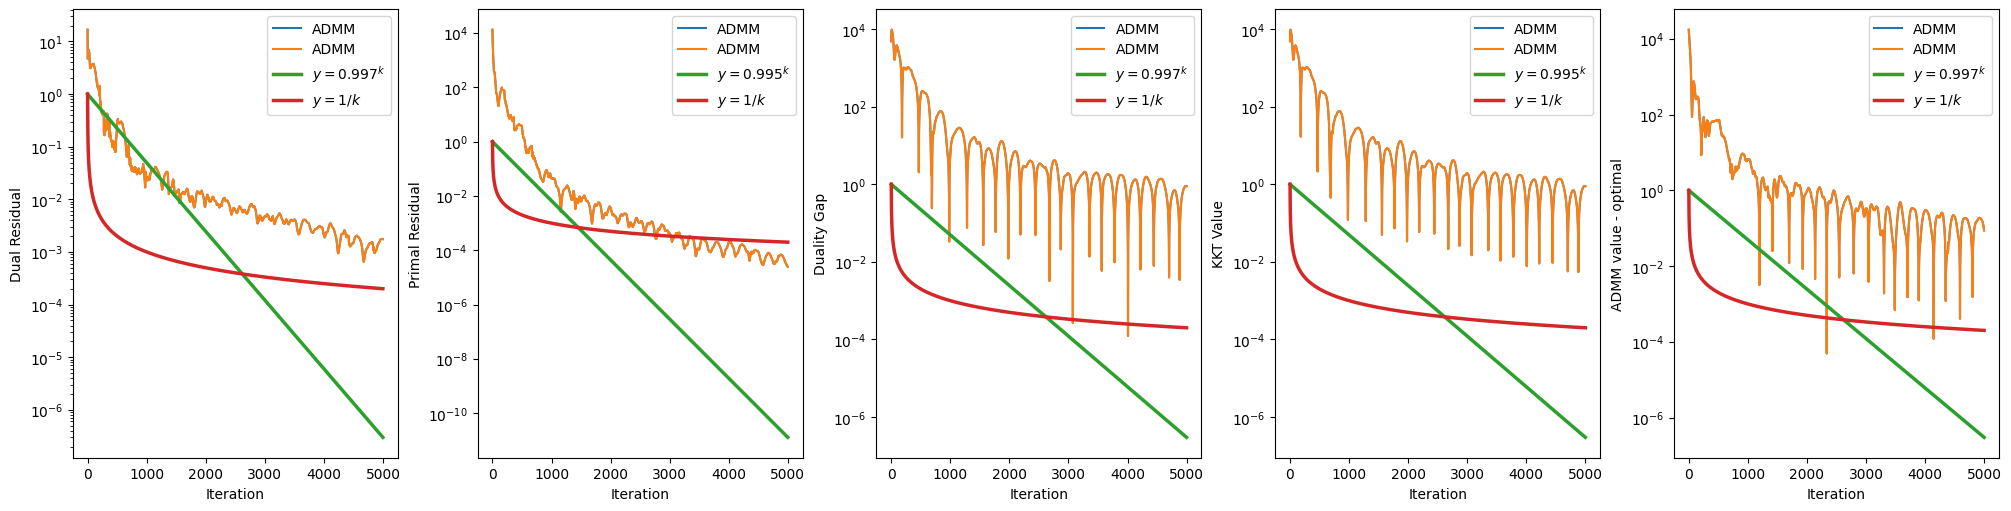

In [7]:
# NOTE
# ADMM

# Importing data
np.random.seed(42)

KKT_valus = []
duality_gap = []
primal_residual = []
dual_residual = []

iterations = 5000

# Imported problem data
Q = np.copy(Q_mat)
p = np.copy(c_mat)


n = A_mat.shape[1]
m = A_mat.shape[0]

A = np.array(np.zeros(n))
b = np.array([0])

# I use seperate for loops to easier track the locations of the ru and rl in the A matrix
for i in range(m):
    if ru_mat[i] != np.inf:
        A = np.vstack([A, A_mat[i,:]])
        b = np.hstack([b, ru_mat[i]])
for i in range(m):
    if rl_mat[i] != -np.inf:
        A = np.vstack([A, -A_mat[i,:]])
        b = np.hstack([b, -rl_mat[i]])
        
n = A.shape[1]
m = A.shape[0]


ub_indx = []
lb_indx = []

for i in range(n):
    if ub_mat[i] != np.inf:
        new_row = np.zeros(n)
        new_row[i] = 1
        A = np.vstack([A, new_row])
        b = np.hstack([b, ub_mat[i]])
        ub_indx.append(i)
for i in range(n):
    if lb_mat[i] != -np.inf:
        new_row = np.zeros(n)
        new_row[i] = -1
        A = np.vstack([A, new_row])
        b = np.hstack([b, -lb_mat[i]])
        lb_indx.append(i)
        

x = np.zeros(n)
s = np.zeros(b.shape[0])
y = np.zeros(b.shape[0])
# NOTE Not sure if rho is the right value, just choose an argibrary one
rho = 0.3

# Implementing CVXPY to get the optimal values
x_cvxpy = cp.Variable(n)
s_cvxpy = cp.Variable(b.shape[0])
objective = cp.Minimize(0.5*cp.quad_form(x_cvxpy, Q) + p.T @ x_cvxpy)
constraints = [A @ x_cvxpy + s_cvxpy == b, s_cvxpy >= 0]
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.CLARABEL, tol_gap_abs=1e-10, tol_gap_rel=1e-10,tol_feas=1e-10, tol_ktratio=1e-10)
print("Did cvxpy converge =", problem.status)
print("cvxpy value =", 0.5*x_cvxpy.value.T @ Q @ x_cvxpy.value + p.T@x_cvxpy.value)


matrix_x = Q + rho * A.T @ A
print("\nQ + rho * A.T @ A is invertible =>", np.linalg.matrix_rank(matrix_x) == matrix_x.shape[1], "\n")

lu = splu(matrix_x)

value_ADMM = []

# Computation for dual residual
ub_matrix = []
for i in ub_indx:
    new_row = np.zeros(n)
    new_row[i] = 1
    ub_matrix.append(new_row)

ub_matrix = np.array(ub_matrix)
    
lb_matrix = []
for i in lb_indx:
    new_row = np.zeros(n)
    new_row[i] = 1
    lb_matrix.append(new_row)
    
lb_matrix = np.array(lb_matrix)

if ub_matrix.shape[0] > 0 and lb_matrix.shape[0] > 0:
    b_matrix = np.vstack([np.zeros((m,n)), ub_matrix, lb_matrix])
elif lb_matrix.shape[0] > 0:
    b_matrix = np.vstack([np.zeros((m,n)), lb_matrix])
elif ub_matrix.shape[0] > 0:
    b_matrix = np.vstack([np.zeros((m,n)), ub_matrix])
else:
    print("ERROR")

Q_inv = np.linalg.pinv(Q)
matrix_constraint = A.T+b_matrix.T

for i in range(iterations):
    
    z_hat, z = ADMM_imported_mat(Q, p, A, b, x, s, y, rho, n, m, lu)
    
    x = z[0]
    s = z[1]
    y = z[2]
    
    val = 0.5*x.T @ Q @ x + p.T@x
    
    value_ADMM.append(abs(val - problem.value))
    
    KKT = KKT_error_imported_mat(rho, Q, p, A, b, x, s, y, m, n, ub_indx, lb_indx, matrix_constraint, Q_inv, val)
    KKT_valus.append(KKT)
    
    # LP Duality Gap
    # I think this is wrong as this is for LP
    # duality_gap.append(abs((b.T@y - val)))
    
    # Duality Gap For QP
    # This is f(x) - g(y)
    # duality_gap.append(abs(0.5*(p - (A.T + b_matrix.T)@ y).T @ Q_inv @ (p - (A.T + b_matrix.T) @ y) + y.T @ b + val))
    # This is the value obtained at optimality
    # duality_gap.append(abs(x.T @ Q @ x + p.T @ x + b.T @ y))
    
    # Duality Gap For QP adjusted
    # I am pretty sure that my dual variables sign should be flipped
    # This is f(x) - g(y)
    # duality_gap.append(abs(0.5*(p + matrix_constraint @ y).T @ Q_inv @ (p + matrix_constraint @ y) - y.T @ b + val))
    # This is the value obtained at optimality
    duality_gap.append(abs(x.T @ Q @ x + p.T @ x - b.T @ y))
    
    # Normalized Duality Gap
    # duality_gap.append(np.sqrt((q.T@(nu*y) + l.T@lam_plus - u.T@lam_minus - c.T@x)**2)/np.sqrt((c.T@x)**2))
    
    primal_residual.append(np.linalg.norm(A@x + s - b)**2)
    
    # Normal Dual Residual
    # dual_residual.append(np.linalg.norm(c - K.T @ (nu*y) - lam_KKT, 2) ** 2)
    
    # ADMM Dual Residual
    # dual_residual.append(np.linalg.norm(c - A.T @ y, 2))
            
    # b_matrix = np.vstack([np.zeros((m,n)), np.eye(ub_count), np.eye(lb_count)])
    
    dual_residual.append(np.linalg.norm(np.minimum(Q @ x + p - matrix_constraint @ y, 0), 2))
    
print("ADMM value =", val)

ADMM = [dual_residual, primal_residual, duality_gap, KKT_valus, value_ADMM]
plot_results(ADMM, ADMM, f'ADMM')

ADMM with Fixed Restarts

Did cvxpy converge = optimal
cvxpy value = 16352.342044821135


C:\Users\baice\AppData\Local\Temp\ipykernel_4076\1469163121.py:88: SparseEfficiencyWarning: splu converted its input to CSC format
  lu = splu(Q + rho * A.T @ A)


For f = 50 we go over 5000 iterations


C:\Users\baice\AppData\Local\Temp\ipykernel_4076\600647710.py:59: RuntimeWarning: divide by zero encountered in divide
  y_value = 1 / k_value


For f = 100 we go over 5000 iterations
For f = 250 we go over 5000 iterations
For f = 500 we go over 5000 iterations
For f = 750 we go over 5000 iterations
For f = 1000 we go over 5000 iterations
For f = 1500 we go over 5000 iterations
For f = 2000 we go over 5000 iterations
ADMM value = 16352.06623161707


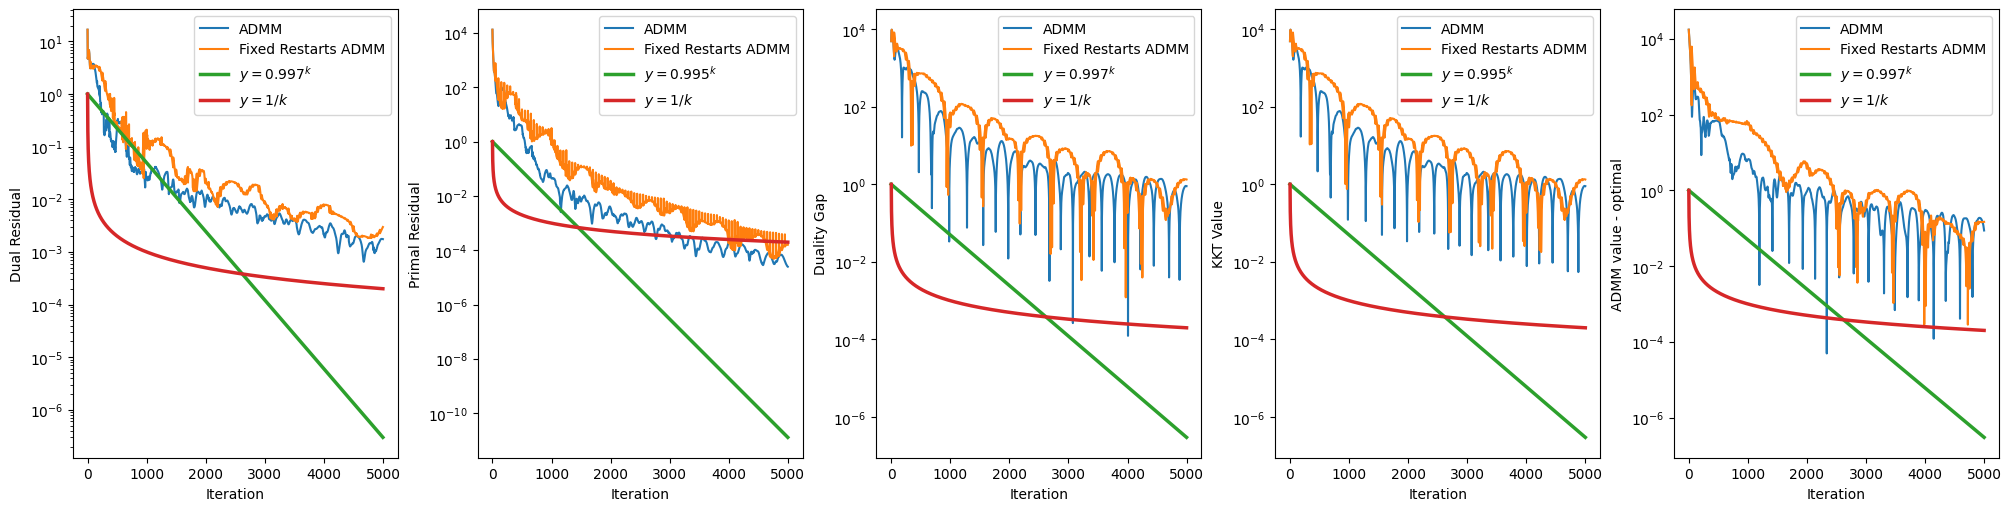

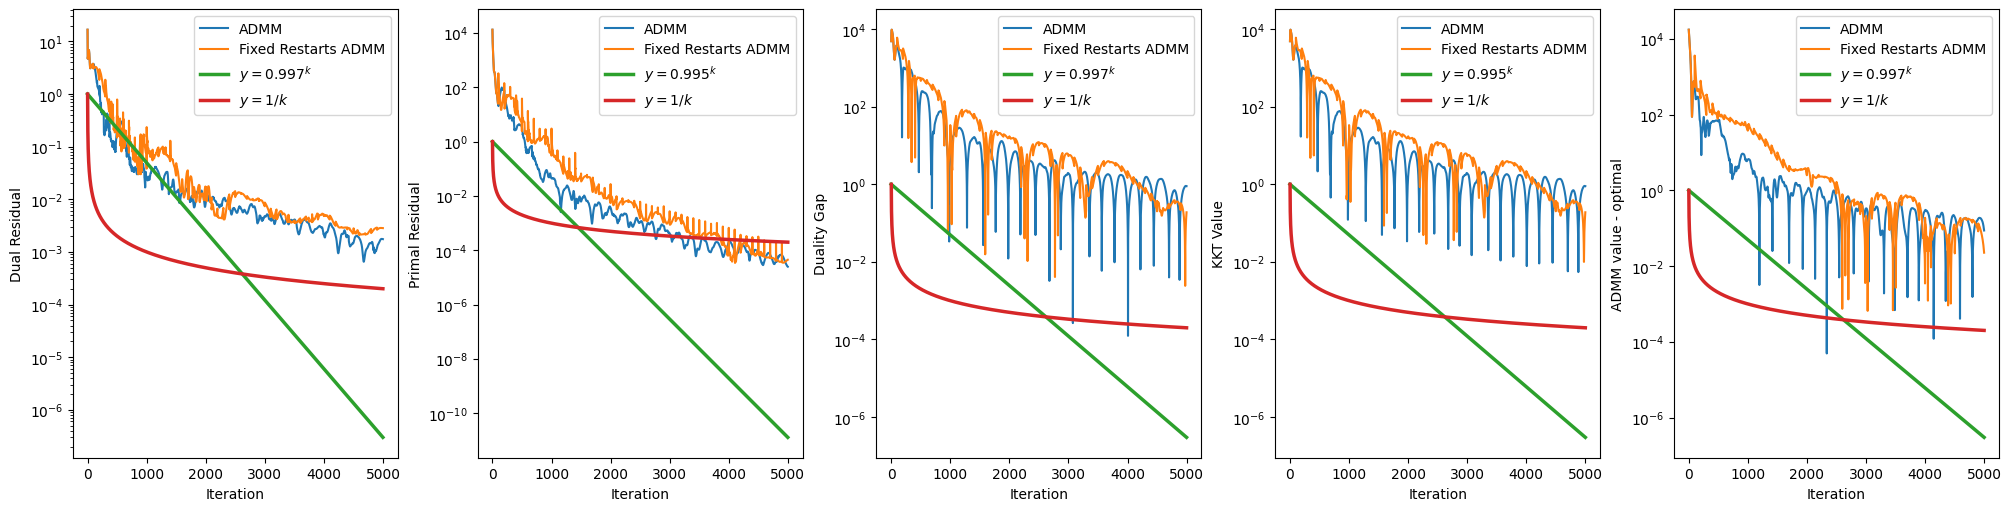

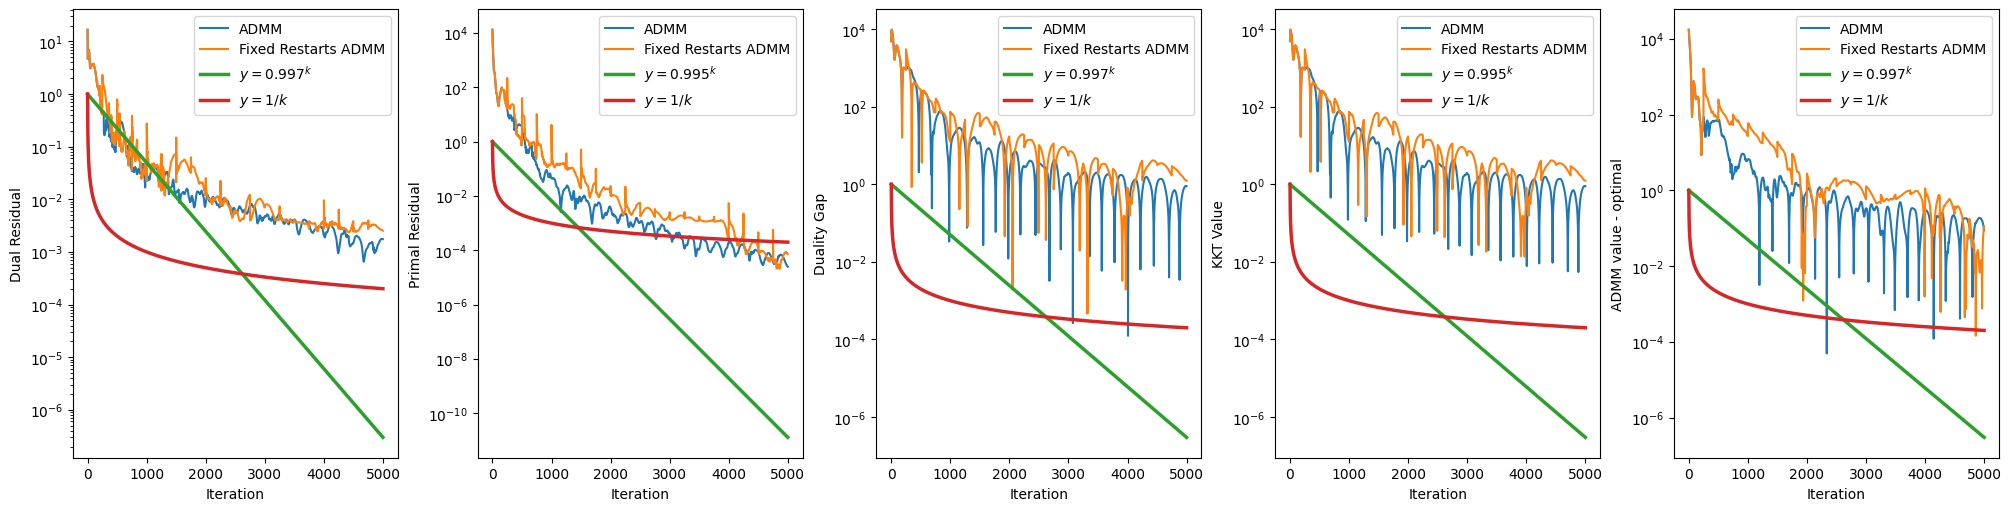

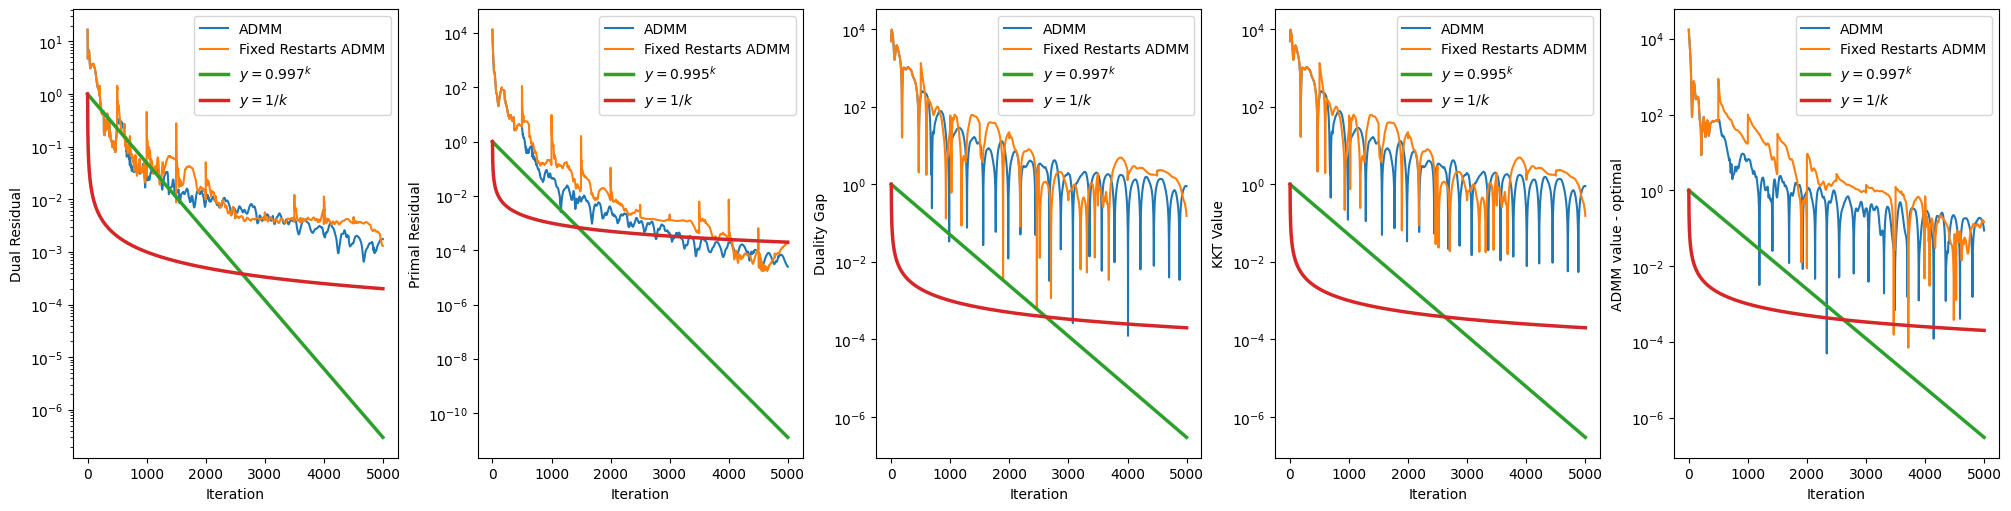

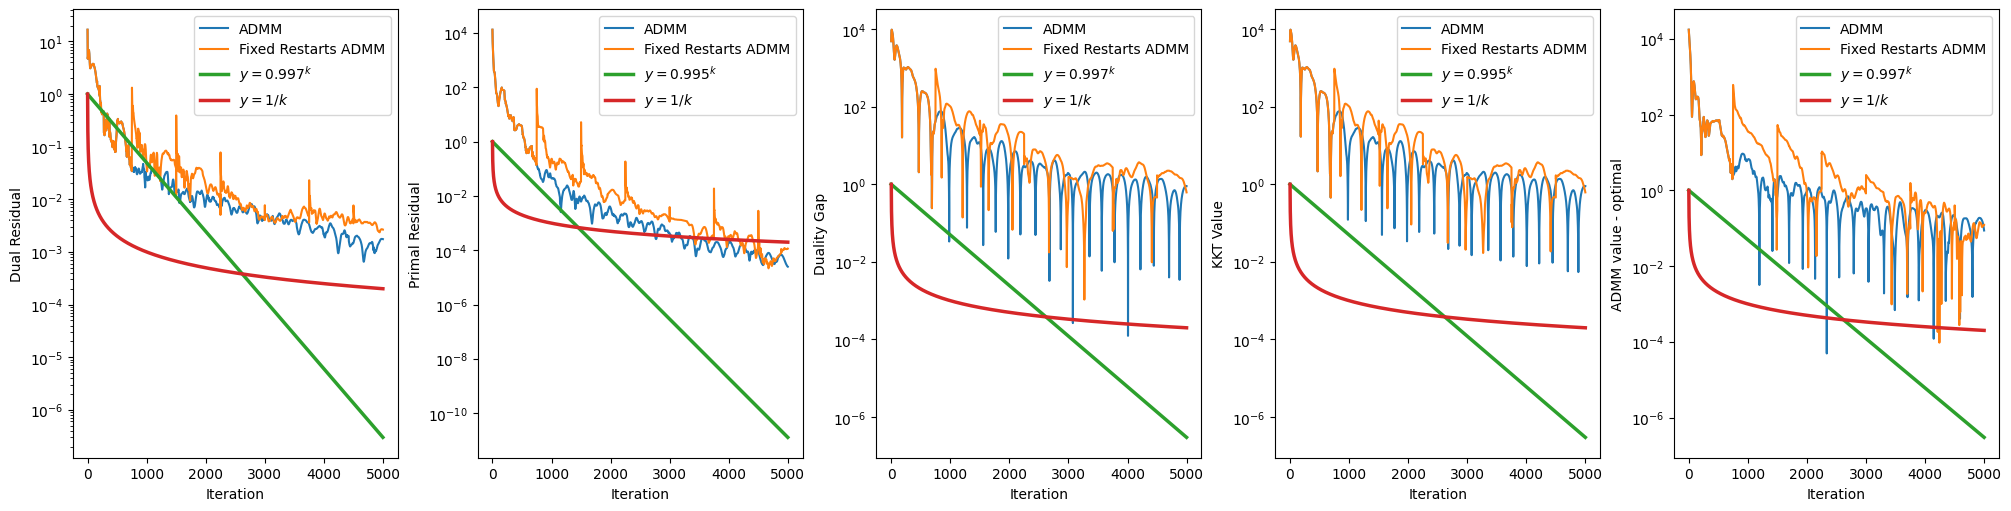

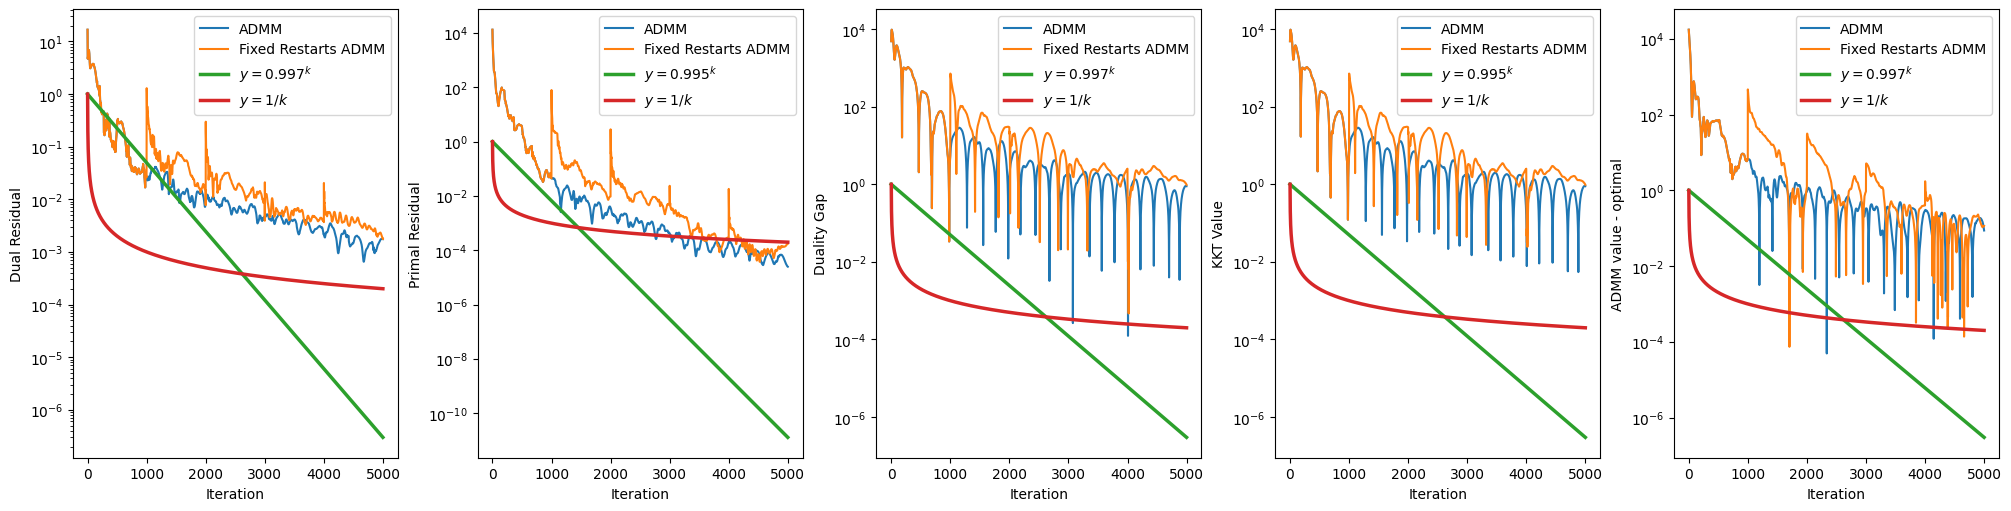

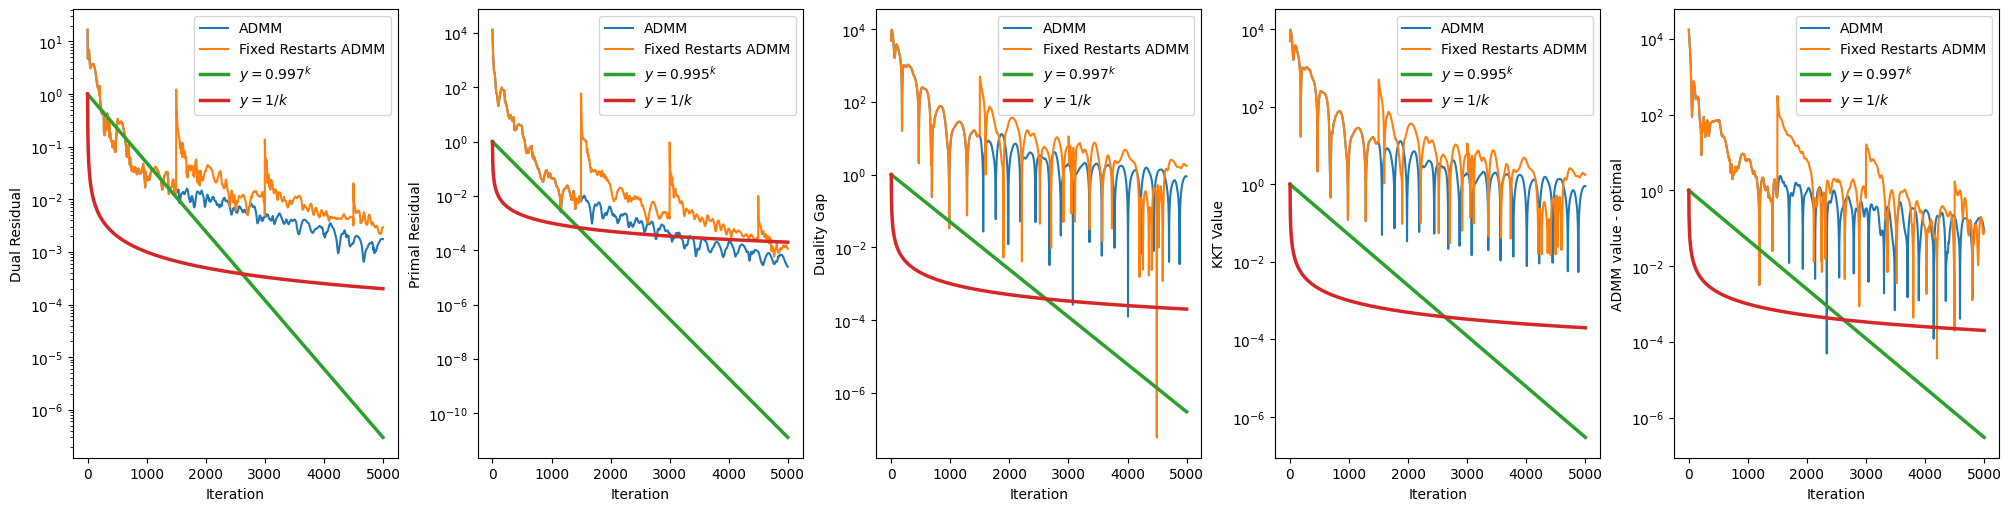

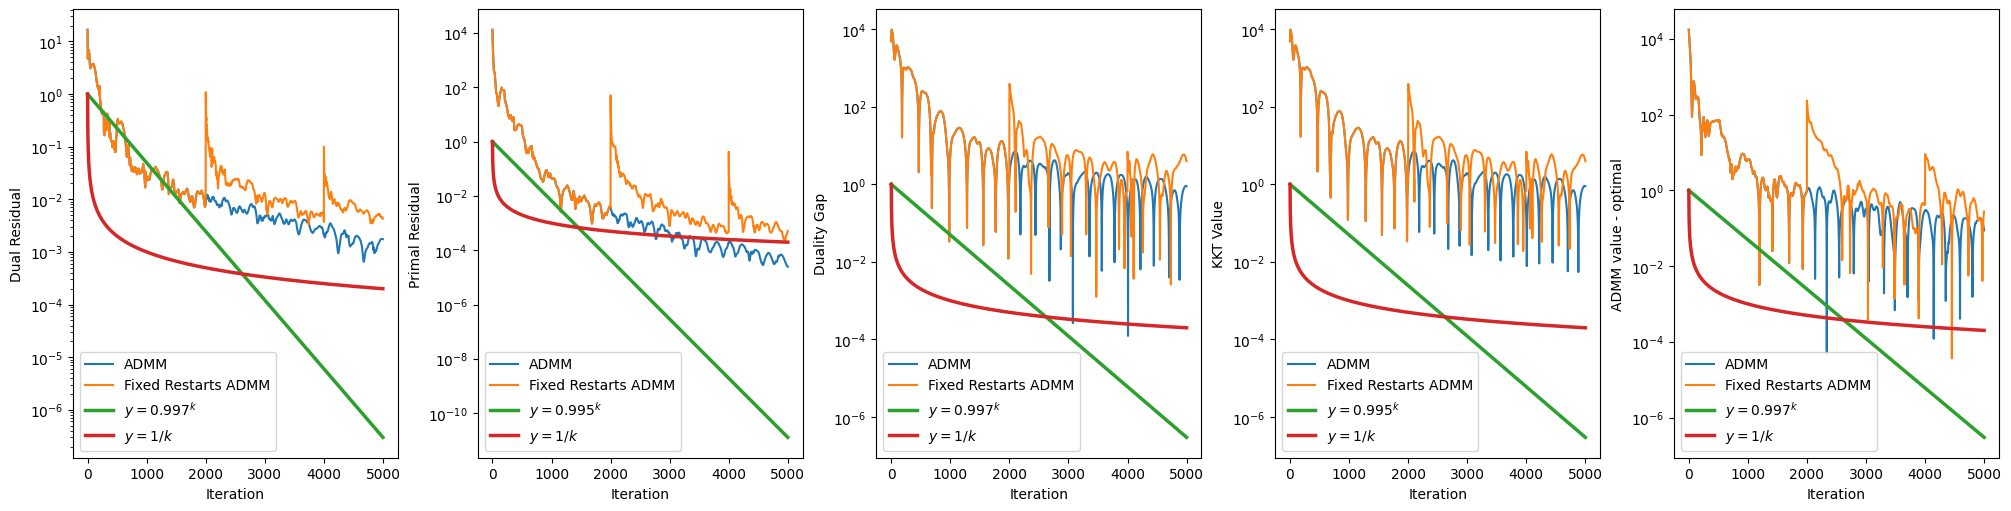

In [8]:

# NOTE
# ADMM + Fixed restarts

ub_inf = True

# Importing data
np.random.seed(42)
np.random.seed(142)

KKT_valus_fix_rest = []
duality_gap_fix_rest = []
primal_residual_fix_rest = []
dual_residual_fix_rest = []
value_ADMM_fix_rest = []

iterations = 5000

# Imported problem data
Q = np.copy(Q_mat)
A = np.copy(A_mat)
p = np.copy(c_mat)
l = np.copy(lb_mat)
u = np.copy(ub_mat)
ru = np.copy(ru_mat)
rl = np.copy(rl_mat)

n = A_mat.shape[1]
m = A_mat.shape[0]

# if ub_inf:
#     A = np.vstack([A, -A, -np.eye(n)])
#     b = np.hstack([ru, -rl, -lb_mat])
# else:
#     A = np.vstack([A, -A, np.eye(n), -np.eye(n)])
#     b = np.hstack([ru, -rl, ub_mat, -lb_mat])


A = np.array(np.zeros(n))
b = np.array([0])

for i in range(m):
    if ru_mat[i] != np.inf:
        A = np.vstack([A, A_mat[i,:]])
        b = np.hstack([b, ru_mat[i]])
for i in range(m):
    if rl_mat[i] != -np.inf:
        A = np.vstack([A, -A_mat[i,:]])
        b = np.hstack([b, -rl_mat[i]])
        
n = A.shape[1]
m = A.shape[0]

ub_indx = []
lb_indx = []

for i in range(n):
    if ub_mat[i] != np.inf:
        new_row = np.zeros(n)
        new_row[i] = 1
        A = np.vstack([A, new_row])
        b = np.hstack([b, ub_mat[i]])
        ub_indx.append(i)
for i in range(n):
    if lb_mat[i] != -np.inf:
        new_row = np.zeros(n)
        new_row[i] = -1
        A = np.vstack([A, new_row])
        b = np.hstack([b, -lb_mat[i]])
        lb_indx.append(i)

x = np.zeros(n)
s = np.zeros(b.shape[0])
y = np.zeros(b.shape[0])
# NOTE Not sure if rho is the right value, just choose an argibrary one
rho = 0.3

# Implementing CVXPY to get the optimal values
x_cvxpy = cp.Variable(n)
s_cvxpy = cp.Variable(b.shape[0])
objective = cp.Minimize(0.5*cp.quad_form(x_cvxpy, Q) + p.T @ x_cvxpy)
constraints = [A @ x_cvxpy + s_cvxpy == b, s_cvxpy >= 0]
# constraints = [A @ x_cvxpy <= b]
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.CLARABEL, tol_gap_abs=1e-10, tol_gap_rel=1e-10,tol_feas=1e-10, tol_ktratio=1e-10)
print("Did cvxpy converge =", problem.status)
print("cvxpy value =", 0.5*x_cvxpy.value.T @ Q @ x_cvxpy.value + p.T@x_cvxpy.value)

lu = splu(Q + rho * A.T @ A)

z = []
z_bar = 0

ub_matrix = []
for i in ub_indx:
    new_row = np.zeros(n)
    new_row[i] = 1
    ub_matrix.append(new_row)

ub_matrix = np.array(ub_matrix)
    
lb_matrix = []
for i in lb_indx:
    new_row = np.zeros(n)
    new_row[i] = 1
    lb_matrix.append(new_row)
    
lb_matrix = np.array(lb_matrix)

if ub_matrix.shape[0] > 0 and lb_matrix.shape[0] > 0:
    b_matrix = np.vstack([np.zeros((m,n)), ub_matrix, lb_matrix])
elif lb_matrix.shape[0] > 0:
    b_matrix = np.vstack([np.zeros((m,n)), lb_matrix])
elif ub_matrix.shape[0] > 0:
    b_matrix = np.vstack([np.zeros((m,n)), ub_matrix])
else:
    print("ERROR")

Q_inv = np.linalg.pinv(Q)
matrix_constraint = A.T+b_matrix.T

for f in [50, 100, 250, 500, 750, 1000, 1500, 2000]:

    count = 0
    x = np.zeros(n)
    s = np.zeros(b.shape[0])
    y = np.zeros(b.shape[0])
    
    KKT_valus_fix_rest = []
    duality_gap_fix_rest = []
    primal_residual_fix_rest = []
    dual_residual_fix_rest = []
    value_ADMM_fix_rest = []
    
    z = []
    z_bar = 0
    
    # Outer Loop
    for i in range(iterations):
        # Reset values
        z.append(z_bar)
        
        x_bar = 0
        s_bar = 0
        y_bar = 0
        
        t = 0
        
        # Inner Loop
        for g in range(f):
            # xv_prev used for KKT
            xv_prev = x
            
            z_hat, z_admm = ADMM_imported_mat(Q, p, A, b, x, s, y, rho, n, m, lu)
            
            x = z_admm[0]
            s = z_admm[1]
            y = z_admm[2]
            
            val = 0.5*x.T @ Q @ x + p.T@x
            
            value_ADMM_fix_rest.append(abs(val - problem.value))
            
            x_bar = (t/(1+t)) * x_bar + (1/(1+t)) * z_hat[0]
            s_bar = (t/(1+t)) * s_bar + (1/(1+t)) * z_hat[1]
            y_bar = (t/(1+t)) * y_bar + (1/(1+t)) * z_hat[2]
            
            KKT = KKT_error_imported_mat(rho, Q, p, A, b, x, s, y, m, n, ub_indx, lb_indx, matrix_constraint, Q_inv, val)
            
            KKT_valus_fix_rest.append(KKT)
            
            # Normal Duality Gap
            # I think this is wrong as this is for LP
            # duality_gap_fix_rest.append(abs((b.T@y - val)))
            
            # Duality Gap For QP adjusted
            # I am pretty sure that my dual variables sign should be flipped
            # This is f(x) - g(y)
            # duality_gap_fix_rest.append(abs(0.5*(p + matrix_constraint @ y).T @ Q_inv @ (p + matrix_constraint @ y) - y.T @ b + val))
            # This is the value obtained at optimality
            duality_gap_fix_rest.append(abs(x.T @ Q @ x + p.T @ x - b.T @ y))
            
            # Duality Gap adjusted
            # duality_gap.append(y.T @ (A @  ))
            
            # Normalized Duality Gap
            # duality_gap.append(np.sqrt((q.T@(nu*y) + l.T@lam_plus - u.T@lam_minus - c.T@x)**2)/np.sqrt((c.T@x)**2))
            
            
            primal_residual_fix_rest.append(np.linalg.norm(A @ x + s - b)**2)
            
            # Normal Dual Residual
            # dual_residual.append(np.linalg.norm(c - K.T @ (nu*y) - lam_KKT, 2) ** 2)
            
            # ADMM Dual Residual
            # dual_residual.append(np.linalg.norm(c - A.T @ y, 2))
            
            # if ub_inf:
            #     # x>=0
            #     b_matrix = np.vstack([np.zeros((m*2,n)), np.eye(n)])
            # else: 
            #     # l<=x<=u
            #     # b_matrix = np.vstack([np.zeros((m,n)), np.eye(n), np.eye(n)])
            #     b_matrix = np.vstack([np.zeros((m*2,n)), np.eye(n), np.eye(n)])            
            
            dual_residual_fix_rest.append(np.linalg.norm(np.minimum(Q @ x + p - matrix_constraint @ y, 0), 2))
            # dual_residual.append(np.linalg.norm(nu * U.T@V@(z[1]- xv_prev),2)**2)
            
            t += 1
            count += 1
            
            if count >= iterations:
                break
        
        if count >= iterations:
            print(f"For f = {f} we go over {iterations} iterations")
            break
        
        x = x_bar
        s = s_bar
        y = y_bar
        z = [x, s, y]
    ADMM = [dual_residual, primal_residual, duality_gap, KKT_valus, value_ADMM]
    ADMM_custom = [dual_residual_fix_rest, primal_residual_fix_rest, duality_gap_fix_rest, KKT_valus_fix_rest, value_ADMM_fix_rest]
    plot_results(ADMM, ADMM_custom, f'Fixed Restarts ADMM')
print("ADMM value =", val)